<a href="https://colab.research.google.com/github/gautham-umasankar/Quantum_COVID/blob/master/Multiclass_GAMA_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

DWave Installation
API token: (will be present on your Dwave accounts' dashboard)

For now, the default solver is the Advantage system, as seen below. For choosing different solvers, we can run !dwave setup and change the default solver, as per the information give below.

Supported Solvers

Solver_Name Description

hybrid_binary_quadratic_model_version2 Hybrid solver for general BQM problems, version 2.0

hybrid_discrete_quadratic_model_version1 Hybrid solver for general DQM problems, version 1.0

hybrid_v1 Hybrid solver for general BQM problems, version 1.0 QPU

Advantage_system1.1 Advantage system

DW_2000Q_6 D-Wave 2000Q lower-noise system

In [ ]:
!pip install dwave-ocean-sdk
!dwave setup

Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: 

D-Wave Drivers installed and up to date.

D-Wave Problem Inspector installed and up to date.

Creating the D-Wave configuration file.
Found existing configuration file: /root/.config/dwave/dwave.conf
Configuration file path [/root/.config/dwave/dwave.conf]: 
Profile (create new or choose from: prod): 
Input required, please try again.
Profile (create new or choose from: prod): prod
API endpoint URL [skip]: 
Authentication token [skip]: CV19-1122fdf8a51f88913cb1641aaec175b4729a3bc4
Default client class [CV19-1122fdf8a51f88913cb1641aaec175b4729a3bc4]: 
Default solver [skip]: 
Configuration saved.


#Import

In [ ]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import time
# Import the Dwave packages dimod and neal
import dimod
import neal
from dwave.system import DWaveSampler, EmbeddingComposite
from minorminer import find_embedding
import dwave
from numpy import linalg as la
import scipy.optimize as scopt
# import pyomo.environ as pyo
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data



In [ ]:
#Loading the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#Normalizing the data
x_train=x_train/255.0
x_test=x_test/255.0

In [ ]:
# Scaling the data
x_train = x_train.reshape([60000, 784])
# q = scale(p)
# x_train = q.reshape([60000,28,28])

x_test = x_test.reshape([10000, 784])
# q = scale(p)
# x_test = q.reshape([10000,28,28])
training_data = []
training_labels = []
validate_data = []
validate_labels = []
test_data = []
test_labels = []

training_data, validate_data, training_labels, validate_labels = train_test_split(x_train, y_train, test_size = 0.2, train_size = 0.8 ,random_state = 10)
print("Number of training images:",len(training_labels))

for i,img in enumerate(x_test):
  test_data.append(np.reshape(img,784))
  test_labels.append(y_test[i])

binary_training_labels = np.array([-1 if training_labels[i]<5 else 1 for i in range(len(training_data))])
binary_validate_labels = np.array([-1 if validate_labels[i]<5 else 1 for i in range(len(validate_data))])

N = 60
batches = np.reshape(training_data, [int(len(training_data)/N), N, len(training_data[0])])
binary_training_labels = np.array([-1 if training_labels[i]<5 else 1 for i in range(len(training_data))])
batches_labels = np.reshape(binary_training_labels, [int(len(binary_training_labels)/N), N])

Number of training images: 48000


# Data for DAG


In [ ]:
l7_indices = np.where(np.array(training_labels) < 8)
l7_training_labels = np.array(training_labels)[l7_indices][0:36000]
l7_training_set = np.array(training_data)[l7_indices][0:36000]
l7_indices = np.where(np.array(validate_labels) < 8)
l7_validate_labels = np.array(validate_labels)[l7_indices][0:9000]
l7_validate_set = np.array(validate_data)[l7_indices][0:9000]

In [ ]:
g3_indices = np.where(np.array(l7_training_labels) > 3)
g3_training_labels = np.array(l7_training_labels)[g3_indices][0:15000]
g3_training_set = np.array(l7_training_set)[g3_indices][0:15000]

In [ ]:
g3_indices = np.where(np.array(l7_validate_labels) > 3)
g3_validate_labels = np.array(l7_validate_labels)[g3_indices][0:4000]
g3_validate_set = np.array(l7_validate_set)[g3_indices][0:4000]

In [ ]:
l6_indices = np.where(g3_training_labels < 6)
l6_training_labels = g3_training_labels[l6_indices][0:6000]
l6_training_set = g3_training_set[l6_indices][0:6000]

In [ ]:
l6_indices = np.where(g3_validate_labels < 6)
l6_validate_labels = g3_validate_labels[l6_indices][0:2000]
l6_validate_set = g3_validate_set[l6_indices][0:2000]

In [ ]:
g6_indices = np.where(g3_training_labels >= 6)
g6_training_labels = g3_training_labels[g6_indices][0:6000]
g6_training_set = g3_training_set[g6_indices][0:6000]

In [ ]:
g6_indices = np.where(g3_validate_labels >= 6)
g6_validate_labels = g3_validate_labels[g6_indices][0:2000]
g6_validate_set = g3_validate_set[g6_indices][0:2000]

In [ ]:
le3_indices = np.where(np.array(l7_training_labels) <= 3)
le3_training_labels = np.array(l7_training_labels)[le3_indices][0:18000]
le3_training_set = np.array(l7_training_set)[le3_indices][0:18000]

In [ ]:
le3_indices = np.where(np.array(l7_validate_labels) <= 3)
le3_validate_labels = np.array(l7_validate_labels)[le3_indices][0:4000]
le3_validate_set = np.array(l7_validate_set)[le3_indices][0:4000]

In [ ]:
l2_indices = np.where(le3_training_labels < 2)
l2_training_labels = le3_training_labels[l2_indices][0:6000]
l2_training_set = le3_training_set[l2_indices][0:6000]

In [ ]:
l2_indices = np.where(le3_validate_labels < 2)
l2_validate_labels = le3_validate_labels[l2_indices][0:2000]
l2_validate_set = le3_validate_set[l2_indices][0:2000]

In [ ]:
g2_indices = np.where(le3_training_labels >= 2)
g2_training_labels = le3_training_labels[g2_indices][0:6000]
g2_training_set = le3_training_set[g2_indices][0:6000]

In [ ]:
g2_indices = np.where(le3_validate_labels >= 2)
g2_validate_labels = le3_validate_labels[g2_indices][0:2000]
g2_validate_set = le3_validate_set[g2_indices][0:2000]

#Bisection


In [ ]:
# Bisection rules for finding best step size
def bisection(g: np.ndarray, fun: Callable, x: np.ndarray, x_lo: np.ndarray = None, x_up: np.ndarray = None, laststep: np.ndarray = None) -> (float, int):
    if np.array_equal(g, laststep):
        return (fun(x), 0)
    if x_lo is None:
        x_lo = np.zeros_like(x)
    if x_up is None:
        x_up = np.ones_like(x)*max(x)*2

    u = max(x_up) - min(x_lo)
    l = -(max(x_up) - min(x_lo))
    for i, gi in enumerate(g):
        if gi >= 1:
            if np.floor((x_up[i] - x[i]) / gi) < u:
                u = int(np.floor((x_up[i] - x[i]) / gi))
            if np.ceil((x_lo[i] - x[i]) / gi) > l:
                l = int(np.ceil((x_lo[i] - x[i]) / gi))
        elif gi <= -1:
            if np.ceil((x_up[i] - x[i]) / gi) > l:
                l = int(np.ceil((x_up[i] - x[i]) / gi))
            if np.floor((x_lo[i] - x[i]) / gi) < u:
                u = int(np.floor((x_lo[i] - x[i]) / gi))
    alpha = u

    while u - l > 1:
        if fun(x + l*g) < fun(x + u*g):
            alpha = l
        else:
            alpha = u
        p1 = int(np.floor((l+u)/2) - 1)
        p2 = int(np.floor((l+u)/2))
        p3 = int(np.floor((l+u)/2) + 1)
        if fun(x + p1*g) < fun(x + p2*g):
            u = int(np.floor((l+u)/2))
        elif fun(x + p3*g) < fun(x + p2*g):
            l = int(np.floor((l+u)/2) + 1)
        else:
            alpha = p2
            break

    if fun(x + l*g) < fun(x + u*g) and fun(x + l*g) < fun(x + alpha*g):
        alpha = l
    elif fun(x + u*g) < fun(x + alpha*g):
        alpha = u

    return (fun(x + alpha*g), alpha)

# GREEDY


In [ ]:
# We can just have a single step move (works well with greedy approach)
def single_move(g: np.ndarray, fun: Callable, x: np.ndarray, x_lo: np.ndarray = None, x_up: np.ndarray = None, laststep: np.ndarray = None) -> (float, int):
    if x_lo is None:
        x_lo = np.zeros_like(x)
    if x_up is None:
        x_up = np.ones_like(x)*max(x)*2

    alpha = 0

    if (x + g <= x_up).all() and (x + g >= x_lo).all():
        if fun(x + g) < fun(x):
            alpha = 1
    elif (x - g <= x_up).all() and (x - g >= x_lo).all():
        if fun(x - g) < fun(x) and fun(x - g) < fun(x + g):
            alpha = -1

    return (fun(x + alpha*g), alpha)

In [ ]:
# Define rules to choose augmentation element, either the best one (argmin) or the first one that is found
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])

def greedy(iterable):
    for i, val in enumerate(iterable):
        if val[1] != 0:
            return i, val
    else:
        return i, val

In [ ]:
def augmentation(grav, func, x, x_lo, x_up, OPTION: int = 1, VERBOSE: bool = True, itermax: int = 1000) -> (int, float, np.ndarray):
    # Let's perform the augmentation and return the number of steps and the best solution
    # OPTION = 1 # Best augmentation, select using bisection rule
    # OPTION = 2 # Greedy augmentation, select using bisection rule
    # OPTION = 3 # Greedy augmentation, select using first found

    dist = 1
    gprev = None
    k = 1
    if VERBOSE:
        print("Initial point:", x)
        print("Objective function:",func(x))
    while dist != 0 and k < itermax:
        if OPTION == 1:
            g1, (obj, dist) = argmin(
                bisection(g=e, fun=func, x=x, laststep=gprev, x_lo=x_lo, x_up=x_up) for e in grav)
        elif OPTION == 2:
            g1, (obj, dist) = greedy(
                bisection(g=e, fun=func, x=x, laststep=gprev, x_lo=x_lo, x_up=x_up) for e in grav)
        elif OPTION == 3:    
            g1, (obj, dist) = greedy(
                single_move(g=e, fun=func, x=x, x_lo=x_lo, x_up=x_up) for e in grav)
        else:
            print("Option not implemented")
            break
        x = x + grav[g1]*dist
        gprev = grav[g1]
        if VERBOSE:
            print("Iteration ", k)
            print(g1, (obj, dist))
            print("Augmentation direction:", gprev)
            print("Distanced moved:", dist)
            print("Step taken:", grav[g1]*dist)
            print("Objective function:", obj)
            print(func(x))
            print("Current point:", x)
            # print("Are constraints satisfied?", const(x))
        else:
            if k%50 == 0:
                print(k)
                print(obj)
        k += 1
    return(k,obj,x)

# Graver and feasible

##Finding Graver

In [ ]:
# Function to get graver basis from annealer. 
# All vectors/matrixes must be in proper shape. No reshaping done inside the function
def find_graver(N,B,K,M,L,A,samples = 1000,K0 = 0,sim = True, annealing_time=5, programming_thermalization=1, readout_thermalization=1):

  AA = A.T@A
  E = []
  for i in range(K):
    E.append(float(B)**(i-K0))
  print("Encoding = ", E)


  E = np.kron(np.eye(N,dtype=float),E)
  Q = E.T@AA@E
  #print("EAE = \n",Q)
  Q = Q + 2*np.diag((L.T@AA@E)[0])
  #print("diag = \n",2*np.diag((L.T@AA@E)[0]))
  #print("Q = \n",Q)
  
  if not sim:
    sampler = DWaveSampler()
    print("Finding Embedding")
    #Calculate Q as a dictionary
    Q_dict = {}
    for i in range(N*K): 
      Q_dict[(i,i)] = Q[i][i]
      for j in range(i+1,N*K):
        Q_dict[(i,j)] = Q[i][j] + Q[j][i]

    #Create N*K clique adjacency matrix
    graph = []
    for i in range(N*K):
      for j in range(i+1,N*K):
        graph.append((i,j))
        
    found_embed = False    
    embed_path = '/content/drive/My Drive/QuIP_project_parth/Pickles/'
    #Load the embedding
    for i in os.listdir(embed_path):
      if int(i.split('.')[0].split('_')[1]) == N*K:
        with open(os.path.join(embed_path,i), 'rb') as f: 
          embedding = pickle.load(f)
        found_embed = True   
        print("Embedding was already there for {} spins".format(N*K)) 
    
    if not found_embed:
      print("Embedding was not already there, finding a new one")
      embedding=find_embedding(graph,sampler.edgelist,random_seed=10)  
      with open('/content/drive/My Drive/QuIP_project_parth/Pickles/embedding_{}.pickle'.format(N*K),'wb') as f:
          pickle.dump(embedding,f)


    #Embed Weights       
    Q_embed = dwave.embedding.embed_qubo(Q_dict,embedding,sampler.adjacency) #Embeds the particular biases/interactions
    #Sample
    sampleset = sampler.sample_qubo(Q_embed, num_reads=samples, annealing_time = annealing_time, programming_thermalization = programming_thermalization, readout_thermalization = readout_thermalization) 
    #Unembed the data
    bqm=dimod.BinaryQuadraticModel.from_qubo(Q_dict)
    response=dwave.embedding.unembed_sampleset(sampleset,embedding,bqm)
    print("Time taken =", response.info["timing"])
 
  else:
    print("Doing simulated Annealing")
    sampler = neal.SimulatedAnnealingSampler()
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat = Q)
    response = sampler.sample(bqm,num_reads = samples)

  response = response.aggregate()

  final = []

  for i in response.record:
    final.append(i[0].astype(float))
  final = np.array(final).T

  #Transform back to original QUIO 
  graver = np.zeros([N,1])
  for i in range(final.shape[1]):
    graver = np.c_[graver, L + E@final[:,i].reshape([N*K,1])]
  graver = graver[:,1:]
  #print("Before post processing graver = ", graver)
  
  print("Shape before removing zero elements = ",graver.shape)

  #Remove zero elements
  graver_1 = np.zeros([N,1])
  for i in range(graver.shape[1]):
    if (graver[:,i].reshape([1,N]) == np.zeros([1,N])).all():
      continue
    else:
      graver_1 = np.c_[graver_1,graver[:,i]]

  graver = graver_1[:,1:]
  
  #print("Graver before filtration= ")
  #print(graver)
  print("Shape after removing zero elements: ",graver.shape)
  post_dict = {}
  #Keep only elements for which Ax = 0
  graver_1 = np.zeros([N,1])
  for i in range(graver.shape[1]):
    if np.all(A@graver[:,i].reshape([N,1]) == np.zeros([M,1])) :
      graver_1 = np.c_[graver_1,graver[:,i]]
    else: 
      if (A@graver[:,i])[0] not in post_dict:
        post_dict[(A@graver[:,i])[0]] = [i]
      else:
        post_dict[(A@graver[:,i])[0]].append(i)
        
  graver_post = graver  
  graver = graver_1[:,1:]
  
  print("Shape before post-processing: ", graver.shape)
  done = []
  for i in post_dict:
    if i not in done:
      if (-i) in post_dict:
        done.append(i)
        done.append(-i)
        key = i if len(post_dict[i])<=len(post_dict[-i]) else -i
        for l_ind,array_ind in enumerate(post_dict[key]):
          graver = np.c_[graver,graver_post[:,array_ind]+graver_post[:,post_dict[-key][l_ind]]]
  print("Shape after post-processing: ",graver.shape)
  print("Checking if all elements are in kernel: ")
  count = 0
  for i in range(graver.shape[1]):
    if A@graver[:,i] == 0:
      count+=1
    else:
      print(i)
      print(A@graver[:,i])
  
  print("The number of kernel elements after post-processing is: ", count)

  #Do conformal minimal filtration
  graver_filtered = np.zeros([N,1])
  for i in range(graver.shape[1]):
    col1 = graver[:,i]
    check = False
    for j in range(graver.shape[1]):
      if j==i:
        continue
      if len(np.where(graver[:,j]*col1<0)[0]) == 0 :
        if len(np.where(np.abs(graver[:,j])<=np.abs(col1))[0]) == N:
          check = True 
          break
    if not check:
      graver_filtered = np.c_[graver_filtered,col1]
  graver_filtered = graver_filtered[:,1:]

  final_graver = list(graver_filtered.T)

  #Filter out elements which repeat in the opposite octant (j = -i)
  final2 = []
  for ind,i in enumerate(final_graver):
    check = True
    for j in range(ind+1,len(final_graver)):
      if np.all(final_graver[j]==-i):
        check = False
    if check:
      #Create opposite octant elements after filtering
      final2.append(i)
      final2.append(-i)

  return final2

##Finding Feasible

In [ ]:
def get_feasible(N, B, K, M, L, A, b, samples=1000,K0 = 0, sim = True, annealing_time=5, programming_thermalization=1, readout_thermalization=1):

    #Create QUBO
    E = []
    for i in range(K):
      E.append(B**(i-K0))
    print("Encoding = ", E)
    E = np.kron(np.eye(N,dtype=int),E)

    AA = A.T@A
    EAE = E.T@AA@E
    diag = 2*np.diag(((L.T@AA - b.T@A)@E)[0])
    Q = EAE + diag
    
    if not sim:
      sampler = DWaveSampler()
      print("Finding Embedding")
      #Calculate Q as a dictionary
      Q_dict = {}
      for i in range(N*K): 
        Q_dict[(i,i)] = Q[i][i]
        for j in range(i+1,N*K):
          Q_dict[(i,j)] = Q[i][j] + Q[j][i]

      #Create N*K clique adjacency matrix
      graph = []
      for i in range(N*K):
        for j in range(i+1,N*K):
          graph.append((i,j))
          
      found_embed = False    
      embed_path = '/content/drive/My Drive/QuIP_project_parth/Pickles/'
      #Load the embedding
      for i in os.listdir(embed_path):
        if int(i.split('.')[0].split('_')[1]) == N*K:
          with open(os.path.join(embed_path,i), 'rb') as f: 
            embedding = pickle.load(f)
          found_embed = True    
          print("Embedding was already there for {} spins".format(N*K))
      
      if not found_embed:
        print("Embedding was not already there, finding a new one")
        embedding=find_embedding(graph,sampler.edgelist,random_seed=10)  
        with open('/content/drive/My Drive/QuIP_project_parth/Pickles/embedding_{}.pickle'.format(N*K),'wb') as f:
            pickle.dump(embedding,f)


      #Embed Weights       
      Q_embed = dwave.embedding.embed_qubo(Q_dict,embedding,sampler.adjacency) #Embeds the particular biases/interactions
      #Sample
      sampleset = sampler.sample_qubo(Q_embed, num_reads=samples, annealing_time = annealing_time, programming_thermalization = programming_thermalization, readout_thermalization = readout_thermalization) 
      #Unembed the data
      bqm=dimod.BinaryQuadraticModel.from_qubo(Q_dict)
      response=dwave.embedding.unembed_sampleset(sampleset,embedding,bqm)
      print("Time taken =", response.info["timing"])

  
    else:
      print("Doing simulated Annealing")
      sampler = neal.SimulatedAnnealingSampler()
      bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(mat = Q)
      response = sampler.sample(bqm,num_reads = samples)


    response = response.aggregate()

    final = []

    for i in response.record:
      final.append(i[0].astype(float))
    final = np.array(final).T
    
    #Transform back to original QUIO 
    feasible = np.zeros([N,1])
    for i in range(final.shape[1]):
      feasible = np.c_[feasible, L + E@final[:,i].reshape([N*K,1])]
    feasible = feasible[:,1:]

    # feasible_final = feasible
    #Taking only elements that are exactly feasible
    feasible_final = np.zeros([N,1])
    for i in range(feasible.shape[1]):
      if np.all(A@feasible[:,i].reshape([N,1]) == b.reshape([M,1])):
        feasible_final = np.c_[feasible_final,feasible[:,i]]
    feasible_final = feasible_final[:,1:]
    
    
    #Converting to list
    final = list(feasible_final.T)
    
    #Removing duplicates
    final = [np.array(i) for i in set(map(tuple, tuple(final)))]
    
    return final

# Model Class without GAMA


In [ ]:
class model_wo_GAMA:
    # class constructor
  def __init__(self, data, labels, N = 10, K = 2, B = 2, gamma = 0.5, zeta = 1, sim = False):
    #This is the set of training data
    self.data = data
    #This is the set of labels for the training data
    self.labels = labels
    # N is the number of training points
    self.N = N
    # K is the number of "bits" used for representation
    self.K = K
    # B is the base we are using for encoding
    self.B = B
    # Precompute and store the kernel in this array
    self.kernel = np.zeros([N,N])
    #Hyperparameter of the rbf kernel
    self.gamma = gamma
    # Lagrangian multiplier for constraints
    self.zeta = zeta
    #Create a matrix and dictionary for the QUBO
    self.Q = np.zeros([K*N, K*N])
    self.Q_dict = {}
    self.Q_embed = {}
    #Matrix of weights
    self.alpha = np.zeros(N)
    #Matrix of Qubit readouts
    self.a = np.zeros(N*K)
    #Box Constraint Hyperparameter
    self.C = sum([self.B**k for k in range(self.K)])
    #Bias parameter
    self.b = 0
    #Quantum hyperparameters in microseconds
    self.annealing_time=5
    self.programming_thermalization=1
    self.readout_thermalization=1
    self.n_read = 1000
    #Embedding Dictionary
    self.embedding = {}
    self.sim = sim
    #DWave sampler instance   
    if self.sim:
      self.sampler = neal.SimulatedAnnealingSampler()
      self.sampleset = []
      self.samples = []
      self.bqm = []
    else:
      self.sampler=DWaveSampler() 
      self.sampleset = []
      self.samples = []
      self.bqm= []

    

  # function to calculate one element of the kernel matrix
  def _calc_kernel_element(self, x_n, x_m, i, j):
    # rbf kernel
    if self.gamma != -1:
      self.kernel[i,j] = (np.e)**(-self.gamma*((la.norm(x_n - x_m))**2))
      self.kernel[j,i] = self.kernel[i,j]
    # linear classifier
    else:
      self.kernel[i,j] = np.dot(x_n, x_m)
      self.kernel[j,i] = self.kernel[i,j]

  # function to call to create and precompute kernel
  def calc_kernel(self):
    print("Calculating Kernel")
    for i in range(self.N):
      for j in range(i, self.N):
        self._calc_kernel_element(self.data[i], self.data[j], i, j)
  
  #Function to calculate the kernel for two given datapoints
  def kernel_two_points(self,x,y):
    return (np.e)**(-self.gamma*((la.norm(x - y))**2))
    
  # create the QUBO matrix
  def calc_QUBO(self):
    print("Calculating QUBO Coefficients")
    self.Q = np.zeros([K*N, K*N])
    #Calculate Q as a matrix
    for m in range(self.N):
      for n in range(self.N):
        for j in range(self.K):
          for k in range(self.K):
            self.Q[(self.K*n)+k, (self.K*m)+j] = 0.5*((self.B**(k+j))*self.labels[n]*self.labels[m]*(self.kernel[n][m]+self.zeta))
            if n==m and k==j:
              self.Q[(self.K*n)+k, (self.K*m)+j] -= self.B**(k)
    #Calculate Q as a dictionary
    for i in range(self.N*self.K): 
      self.Q_dict[(i,i)] = self.Q[i][i]
      for j in range(i+1,self.N*self.K):
        self.Q_dict[(i,j)] = self.Q[i][j] + self.Q[j][i]

  
  #Function to find the bias parameter
  def calc_b(self):
    print("Finding the bias parameter")
    denom = sum(i*(self.C-i) for i in self.alpha)
    numer = sum([self.alpha[n]*(self.C-self.alpha[n])*(self.labels[n] - sum([self.alpha[m]*self.labels[m]*self.kernel[m,n] for m in range(self.N)])) for n in range(self.N)])
    self.b = numer[0]/denom[0]

  #Function to find the embedding
  def find_embedding(self):
    if self.sim:
      pass
    else:
      print("Finding Embedding")
      #Create N*K clique adjacency matrix
      self.graph = []
      for i in range(N*K):
        for j in range(i+1,N*K):
          self.graph.append((i,j))
      
      #Load the embedding
      if self.N*self.K == 100:
        with open("/content/drive/My Drive/QuIP_Project/Pickles/embedding.pickle", 'rb') as f: 
          self.embedding = pickle.load(f)
      elif self.N*self.K == 120:
        with open("/content/drive/My Drive/QuIP_Project/Pickles/embedding_120.pickle", 'rb') as f: 
          self.embedding = pickle.load(f)
      else:
          print("Embedding was not already there, finding a new one")
          self.embedding=find_embedding(self.graph,self.sampler.edgelist,random_seed=10)  
          with open('/content/drive/My Drive/QuIP_Project/Pickles/embedding_{}.pickle'.format(self.N*self.K),'wb') as f:
              pickle.dump(Model_save,f)
    
  #Function to sample the D-Wave Quantum computer
  def quantum_sample(self):
    
    if self.sim:
      print("Optimizing QUBO on Simulator")
      self.sampleset = self.sampler.sample_qubo(self.Q_dict, num_reads=self.n_read, answer_mode='histogram', annealing_time = self.annealing_time, programming_thermalization = self.programming_thermalization, readout_thermalization = self.readout_thermalization) 
      self.a = np.array(list(self.sampleset.first.sample.values()))
      self.a = np.reshape(self.a,(self.N,self.K))
      self.alpha = self.a.dot(np.array([[self.B**i] for i in range(self.K)]))
    else:
      print("Optimizing QUBO on DWave")
      #Embed Weights       
      self.Q_embed = dwave.embedding.embed_qubo(self.Q_dict,self.embedding,self.sampler.adjacency) #Embeds the particular biases/interactions
      #Sample
      self.sampleset = self.sampler.sample_qubo(self.Q_embed, num_reads=self.n_read, answer_mode='histogram', annealing_time = self.annealing_time, programming_thermalization = self.programming_thermalization, readout_thermalization = self.readout_thermalization) 
      #Unembed the data
      self.bqm=dimod.BinaryQuadraticModel.from_qubo(self.Q_dict)
      self.samples=dwave.embedding.unembed_sampleset(self.sampleset,self.embedding,self.bqm)
      self.a = np.array(list(self.samples.first.sample.values()))
      self.a = np.reshape(self.a,(self.N,self.K))
      self.alpha = self.a.dot(np.array([[self.B**i] for i in range(self.K)]))

  #Function for the decision rule
  def decision(self,x):
    decision_final = np.sign(sum([self.alpha[n]*self.labels[n]*self.kernel_two_points(self.data[n],x) for n in range(self.N)])+self.b)
    if type(decision_final) == np.ndarray:
      return decision_final[0]
    else:
      return decision_final 
  
  def validation(self, validate_data = validate_data, validate_labels = binary_validate_labels, validate_N = 3000):
    print("Validating model")
    validate_N = validate_N #Number of elements for which the model is validated
    print("Number of elements the model is validated for = ", validate_N)
    batch_validate_x = []
    batch_validate_labels = []
    for i in range(validate_N):
      batch_validate_x.append(validate_data[i])
      batch_validate_labels.append(validate_labels[i])
    predictions = np.array([self.decision(x) for x in batch_validate_x])
    print(predictions)
    self.accuracy = (len(np.where(np.array(batch_validate_labels) == np.array(predictions))[0])/validate_N)*100
    print("Accuracy of the classifier: ", self.accuracy)
    return self.accuracy, predictions

  def training_accuracy(self):
    print("Finding Training Accuracy of the model")
    predictions = np.array([self.decision(x) for x in self.data])
    self.accuracy_train = (len(np.where(self.labels == predictions)[0])/self.N)*100
    print("Training Accuracy of the classifier: ", self.accuracy_train)
    return self.accuracy_train


# Testing without GAMA


In [ ]:
N = 100
K = 2
B = 2
batches = np.reshape(training_data, [int(len(training_data)/N), N, len(training_data[0])])
binary_training_labels = np.array([-1 if training_labels[i]<5 else 1 for i in range(len(training_data))])
batches_labels = np.reshape(binary_training_labels, [int(len(binary_training_labels)/N), N])

model_wo_GAMA_obj = model_wo_GAMA(batches[i], batches_labels[i], N, K, B, gamma = 0.02,zeta = 100,sim = True)
model_wo_GAMA_obj.calc_kernel()
model_wo_GAMA_obj.calc_QUBO()
model_wo_GAMA_obj.find_embedding()
model_wo_GAMA_obj.quantum_sample()
model_wo_GAMA_obj.calc_b()
model_wo_GAMA_obj.training_accuracy()
model_wo_GAMA_obj.validation()

Calculating Kernel
Calculating QUBO Coefficients
Optimizing QUBO on Simulator
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  93.0
Validating model
Number of elements the model is validated for =  3000
[ 1.  1.  1. ... -1.  1. -1.]
Accuracy of the classifier:  71.2


(71.2, array([ 1.,  1.,  1., ..., -1.,  1., -1.]))

# Objective

In [ ]:
# Need to define our objective function over here
kernel = None
labels = None
def obj(X):
  global kernel, labels
  # print("X at the start = ",X)
  N = len(X)
  x = np.zeros(N)
  # print(x)
  for i in range(len(labels)):
    x[i] = X[i]*labels[i]
  x = x.reshape([N,1])
  out = (x.T)@kernel@x
  out /= 2
  out -= sum(X)
  # print("X at the end = ",X)
  return out[0][0]

# Model class for GAMA



In [ ]:
class model:
    # class constructor
  def __init__(self, data, labels, N = 10, K = 2, B = 2, gamma = 0.02, zeta = 5, sim = False):
    #This is the set of training data
    self.data = data
    #This is the set of labels for the training data
    self.labels = labels
    # N is the number of training points
    self.N = N
    # K is the number of "bits" used for representation
    self.K = K
    # B is the base we are using for encoding
    self.B = B
    # Precompute and store the kernel in this array
    self.kernel = np.zeros([N,N])
    #Hyperparameter of the rbf kernel
    self.gamma = gamma
    # Lagrangian multiplier for constraints
    self.zeta = zeta
    #Create a matrix and dictionary for the QUBO
    self.Q = np.zeros([K*N, K*N])
    self.Q_dict = {}
    self.Q_embed = {}
    #Matrix of weights
    self.alpha = np.zeros(N)
    #Matrix of Qubit readouts
    self.a = np.zeros(N*K)
    #Box Constraint Hyperparameter
    self.C = sum([self.B**k for k in range(self.K)])
    #Bias parameter
    self.b = 0
    #Quantum hyperparameters in microseconds
    self.annealing_time=5
    self.programming_thermalization=1
    self.readout_thermalization=1
    self.n_read = 1000
    #Embedding Dictionary
    self.embedding = {}
    self.sim = sim
    #DWave sampler instance   
    if self.sim:
      self.sampler = neal.SimulatedAnnealingSampler()
      self.sampleset = []
      self.samples = []
      self.bqm = []
    else:
      self.sampler=DWaveSampler() 
      self.sampleset = []
      self.samples = []
      self.bqm= []

  # function to calculate one element of the kernel matrix
  def _calc_kernel_element(self, x_n, x_m, i, j):
    # rbf kernel
    if self.gamma != -1:
      # print((la.norm(x_n - x_m))**2)
      self.kernel[i,j] = (np.e)**(-self.gamma*((la.norm(x_n - x_m))**2))
      self.kernel[j,i] = self.kernel[i,j]
    # linear classifier
    else:
      self.kernel[i,j] = np.dot(x_n, x_m)
      self.kernel[j,i] = self.kernel[i,j]

  # function to call to create and precompute kernel
  def calc_kernel(self):
    print("Calculating Kernel")
    for i in range(self.N):
      for j in range(i, self.N):
        self._calc_kernel_element(self.data[i], self.data[j], i, j)
  
  #Function to calculate the kernel for two given datapoints
  def kernel_two_points(self,x,y):
    return (np.e)**(-self.gamma*((la.norm(x - y))**2))
  
  def calc_b(self, C):
    print("Finding the bias parameter")
    self.C = C
    denom = sum(i*(self.C-i) for i in self.alpha)
    # print(denom)
    numer = sum([self.alpha[n]*(self.C-self.alpha[n])*(self.labels[n] - sum([self.alpha[m]*self.labels[m]*self.kernel[m,n] for m in range(self.N)])) for n in range(self.N)])
    # print(numer)
    self.b = numer/denom
    # print(self.b)

  # #Function for the decision rule
  def decision(self,x):
    decision_final = sum([self.alpha[n]*self.labels[n]*self.kernel_two_points(self.data[n],x) for n in range(self.N)])+self.b
    # print(decision_final)
    decision_final = np.sign(decision_final)
    if type(decision_final) == np.ndarray:
      return decision_final[0]
    else:
      return decision_final 
  
  def validation(self, validate_data = validate_data, validate_labels = binary_validate_labels, validate_N = 3000):
    print("Validating model")
    validate_N = validate_N #Number of elements for which the model is validated
    print("Number of elements the model is validated for = ", validate_N)
    batch_validate_x = []
    batch_validate_labels = []
    for i in range(validate_N):
      batch_validate_x.append(validate_data[i])
      batch_validate_labels.append(validate_labels[i])
    predictions = np.array([self.decision(x) for x in batch_validate_x])
    print(predictions)
    self.accuracy = (len(np.where(np.array(batch_validate_labels) == np.array(predictions))[0])/validate_N)*100
    print("Accuracy of the classifier: ", self.accuracy)
    return self.accuracy, predictions

  def training_accuracy(self):
    print("Finding Training Accuracy of the model")
    predictions = np.array([self.decision(x) for x in self.data])
    self.accuracy_train = (len(np.where(self.labels == predictions)[0])/self.N)*100
    print("Training Accuracy of the classifier: ", self.accuracy_train)
    return self.accuracy_train


# Testing single SVM here

##Setting up a Batch

In [ ]:
i = np.random.randint(len(batches))
A = batches_labels[i]
A = A.reshape([1,len(A)])
b = np.array([[0]])

K = 2
B = 2
model_obj = model(batches[i], batches_labels[i], N, K, B, gamma = 0.01,zeta = 100,sim = True)
model_obj.calc_kernel()
kernel = model_obj.kernel
labels = model_obj.labels


Calculating Kernel


##Finding Graver Bases

In [ ]:
M = 1
B = 2
K = 2
K0 = 2
L = np.zeros([1,N]).T - 0.5

#Defining the sampler has been done in the function
start = time.process_time()
r = find_graver(N,B,K,M,L,A,samples = 100, K0 = K0, sim = False)
print("Time taken to find graver basis: ", time.process_time() - start, "seconds")

print("Length of Graver basis = ", len(r))
#print("Feasible solutions = \n", feas_sols)
#print("Graver basis = \n", r)
r = np.array(r)
#print(r)


Finding Embedding
Embedding was not already there, finding a new one
Time taken = {'qpu_sampling_time': 13466, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 38490, 'qpu_access_overhead_time': 9109, 'qpu_programming_time': 25024, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 520, 'total_post_processing_time': 2881, 'total_real_time': 38490, 'run_time_chip': 13466, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 100)
Shape after removing zero elements:  (60, 100)
Shape before post-processing:  (60, 9)
Shape after post-processing:  (60, 34)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  34
Time taken to find graver basis:  500.155523938 seconds
Length of Graver basis =  68


In [ ]:
count = 0
for i in r:
  if (A@i)[0] == 0:
    count+=1
print(count)

1998


##Finding Feasible Solutions

In [ ]:
B = 2
K = 2
L = np.zeros([1,N]).T
K0 = 2

start = time.process_time()
feas_sols = get_feasible(N,B,K,M,L,A,b,samples = 1000, K0 = K0, sim = False)
print("Time taken to find feasible solutions: ", time.process_time() - start, "seconds")

print("Number of feasible solutions = ",len(feas_sols))
feas_sols = np.array(feas_sols)

Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159692, 'qpu_access_overhead_time': 24260, 'qpu_programming_time': 25032, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 227, 'total_post_processing_time': 32638, 'total_real_time': 159692, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Time taken to find feasible solutions:  1.7619054910001068 seconds
Number of feasible solutions =  82


##Performing Augmentation

Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective
Total time:  0.6066915999999765 seconds 
Best solution =  -30.687221094351987  for x = 
 [0.5  0.75 0.   1.5  0.5  1.5  1.   0.5  1.   0.25 1.25 0.5  1.25 0.5
 0.5  0.   1.   0.5  1.25 0.75 0.75 0.75 1.5  0.75 0.25 1.25 0.   0.5
 1.   0.5  0.25 1.5  1.   0.   1.5  1.25 0.5  1.75 1.25 0.75 0.75 1.5
 1.   0.5  1.5  1.5  0.5  0.5  1.25 0.   1.   0.25 1.25 0.   1.25 1.25
 0.   0.   0.25 0.75]


Text(0.5, 0, 'Feasible solution')

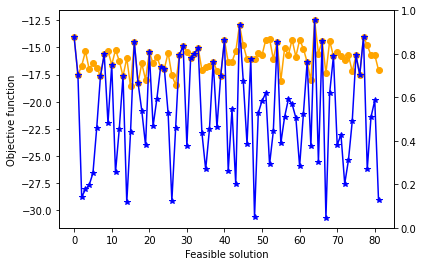

In [ ]:
print('Greedy-augmentation: Choosing among the first element of G that with a single step reduces the objective')
init_obj = np.zeros((len(feas_sols),1))
iters_full = np.zeros((len(feas_sols),1))
final_obj_full = np.zeros((len(feas_sols),1))
times_full = np.zeros((len(feas_sols),1))
start_2 = time.process_time()
best_sol = 100000
for index, i in enumerate(feas_sols):
  init_obj[index] = obj(i)
  start = time.process_time()
  iter,f_obj,xf = augmentation(grav = r, func = obj, x = i, x_lo = 0*np.ones_like(i), x_up = 2*np.ones_like(i), OPTION=3,VERBOSE=False)
  # print(time.process_time() - start, 'seconds')""
  # print(iter, 'iterations')
  # print('solution:',f_obj,xf)
  if(f_obj <= best_sol):
    best_sol = f_obj
    best_arg = xf
  final_obj_full[index] = f_obj
print("Total time: ", time.process_time() - start_2, 'seconds',"\nBest solution = ", best_sol, " for x = \n", best_arg)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(init_obj, color = 'orange', marker='o', ls='-', label='Initial')
ax1.plot(final_obj_full, color = 'blue', marker='*', ls='-', label='Final')
ax1.set_ylabel('Objective function')
ax1.set_xlabel('Feasible solution')

##Validating the Model

In [ ]:
model_obj.alpha = best_arg
for i in np.linspace(0,0.5, 1):
  model_obj.calc_b(10000)
  # model_obj.b = 0
  model_obj.training_accuracy()
  _, predictions = model_obj.validation(validate_data, binary_validate_labels)

Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  96.66666666666667
Validating model
Number of elements the model is validated for =  3000
[-1. -1. -1. ... -1.  1.  1.]
Accuracy of the classifier:  72.86666666666667


#Classical Optimization

##Optimizing with scipy

In [ ]:
x0 = np.ones(N)
#print(A.reshape((N,)))
#print(kernel)
print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

print(np.around(res.x,2))

[2.]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.813213352481824
            Iterations: 21
            Function evaluations: 1304
            Gradient evaluations: 21
Total time for scipy:  0.17066924299999187 seconds
[0.59 2.   0.23 2.   1.54 1.74 0.65 0.13 2.   0.97 0.96 2.   2.   0.6
 2.   0.12 0.96 1.84 2.   0.   2.   1.61 0.   2.   1.27 1.17 1.23 1.09
 0.59 1.35 0.26 0.41 1.37 2.   2.   0.93 0.15 1.61 0.   1.32 0.27 1.16
 2.   0.69 0.   0.1  1.05 0.36 1.96 0.18 1.8  0.   2.   0.92 2.   2.
 1.54 1.53 2.   0.85]


##Validate Classical SVM (scipy optimization)

In [ ]:
model_obj.alpha = res.x
print(np.around(res.x,2))
print(obj(res.x))
for i in np.linspace(0.2,0.4, 1):
  model_obj.calc_b(2)
  model_obj.training_accuracy()
  model_obj.validation()

[0.59 2.   0.23 2.   1.54 1.74 0.65 0.13 2.   0.97 0.96 2.   2.   0.6
 2.   0.12 0.96 1.84 2.   0.   2.   1.61 0.   2.   1.27 1.17 1.23 1.09
 0.59 1.35 0.26 0.41 1.37 2.   2.   0.93 0.15 1.61 0.   1.32 0.27 1.16
 2.   0.69 0.   0.1  1.05 0.36 1.96 0.18 1.8  0.   2.   0.92 2.   2.
 1.54 1.53 2.   0.85]
-38.813213352481824
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0
Validating model
Number of elements the model is validated for =  3000
[-1. -1. -1. ... -1.  1.  1.]
Accuracy of the classifier:  73.0


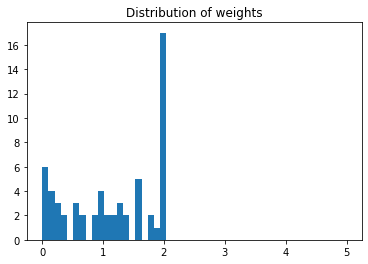

In [ ]:
plt.hist(res.x, bins = np.linspace(0,5,50))
plt.title("Distribution of weights")
plt.show()

# Ensemble Class

In [ ]:
class Ensemble:
  def __init__(self, model, training_batches, training_batches_labels, sim = True, ensemble_length = 10):
    global kernel, labels
    N = len(training_batches_labels[0])
    print("N = ", N)
    self.ensemble = [model(training_batches[i], training_batches_labels[i], N, 2, 2, gamma = 0.01,zeta = 100,sim = sim) for i in range(ensemble_length)]
    for i in range(ensemble_length):
      print("SVM number ",i)
      A = training_batches_labels[i]
      A = A.reshape([1,len(A)])
      b = np.array([[0]])
      self.ensemble_length = ensemble_length

      self.ensemble[i].calc_kernel()
      kernel = self.ensemble[i].kernel
      labels = self.ensemble[i].labels
      
      M = 1
      B = 2
      K = 2
      L = np.zeros([1,N]).T - 0.5
      K0 = 2

      sampler = neal.SimulatedAnnealingSampler()
      # sampler = DWaveSampler()
      start = time.process_time()
      r = find_graver(N,B,K,M,L,A,samples = 1000, sim = sim, K0 = K0)
      print("Time taken to find graver basis: ", time.process_time() - start, "seconds")

      B = 2
      K = 2
      L = np.zeros([1,N]).T
      K0 = 2
      upper = sum([B**i for i in range(K)])

      start = time.process_time()
      feas_sols = get_feasible(N,B,K,M,L,A,b,samples = 10000, sim = sim, K0 = K0)
      print("Time taken to find feasible solutions: ", time.process_time() - start, "seconds")
      print("Number of feasible solutions = ",len(feas_sols))
      print("Length of Graver basis = ", len(r))

      r = np.array(r)
      feas_sols = np.array(feas_sols)
      init_obj = np.zeros((len(feas_sols),1))
      iters_full = np.zeros((len(feas_sols),1))
      final_obj_full = np.zeros((len(feas_sols),1))
      times_full = np.zeros((len(feas_sols),1))
      start_2 = time.process_time()
      best_sol = 100000
      for index, sol in enumerate(feas_sols):
        init_obj[index] = obj(sol)
        start = time.process_time()
        iter,f_obj,xf = augmentation(grav = r, func = obj, x = sol, x_lo = 0*np.ones_like(sol), x_up = 2*np.ones_like(sol), OPTION=3,VERBOSE=False)
        if(f_obj <= best_sol):
          best_sol = f_obj
          best_arg = xf
        final_obj_full[index] = f_obj

      self.ensemble[i].alpha = best_arg
      self.ensemble[i].calc_b(3)
      self.ensemble[i].training_accuracy()

  def validate_models(self, validate_data, validate_labels, validate_N = 3000):
    validate_N = validate_N
    for i in range(self.ensemble_length):
      self.ensemble[i].validation(validate_data, validate_labels, validate_N)


  def prediction(self, val):
    prediction_ensemble = []
    for i in self.ensemble:
      prediction_ensemble.append(i.decision(val))
    return np.sign(sum(prediction_ensemble))
    
  def validate_ensemble(self, validate_data, validate_labels):
    print("Finding accuracy of ensemble...")
    final_prediction = np.zeros(len(validate_labels))
    for i, val in enumerate(validate_data):
      final_prediction[i] = self.prediction(val)
    accuracy = len(np.where(np.array(validate_labels)== final_prediction)[0])/len(validate_data)*100
    print("The accuracy of the ensemble is: ",accuracy)
    return accuracy

# Testing Ensemble

In [ ]:
binary_validate_labels = np.array([-1 if validate_labels[i]<5 else 1 for i in range(len(validate_data))])
N = 50
ensemble_length = 5
batches = np.reshape(training_data, [int(len(training_data)/N), N, len(training_data[0])])
binary_training_labels = np.array([-1 if training_labels[i]<5 else 1 for i in range(len(training_data))])
batches_labels = np.reshape(binary_training_labels, [int(len(binary_training_labels)/N), N])

ensemble = Ensemble(model, batches, batches_labels, ensemble_length=ensemble_length)

N =  50
SVM number  0
Calculating Kernel
Doing simulated Annealing
Shape before removing zero elements =  (50, 100)
Shape after removing zero elements:  (50, 100)
Shape before post-processing:  (50, 100)
Shape after post-processing:  (50, 100)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  100
Time taken to find graver basis:  1.9318902109999954 seconds
Doing simulated Annealing
Time taken to find feasible solutions:  1.1735153719999971 seconds
Number of feasible solutions =  50
Length of Graver basis =  200
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  96.0
SVM number  1
Calculating Kernel
Doing simulated Annealing
Shape before removing zero elements =  (50, 100)
Shape after removing zero elements:  (50, 100)
Shape before post-processing:  (50, 100)
Shape after post-processing:  (50, 100)
Checking if all elements are in kernel: 
The number of kernel elements after post-processi

In [ ]:
ensemble.validate_models(validate_data, binary_validate_labels)
ensemble.validate_ensemble(validate_data, binary_validate_labels)

Validating model
Number of elements the model is validated for =  3000
[ 1.  1.  1. ... -1. -1. -1.]
Accuracy of the classifier:  68.93333333333334
Validating model
Number of elements the model is validated for =  3000
[ 1.  1.  1. ... -1.  1.  1.]
Accuracy of the classifier:  67.63333333333334
Validating model
Number of elements the model is validated for =  3000
[-1. -1. -1. ... -1. -1.  1.]
Accuracy of the classifier:  70.53333333333333
Validating model
Number of elements the model is validated for =  3000
[-1.  1.  1. ... -1. -1.  1.]
Accuracy of the classifier:  73.36666666666667
Validating model
Number of elements the model is validated for =  3000
[-1. -1. -1. ... -1. -1.  1.]
Accuracy of the classifier:  68.10000000000001
Finding accuracy of ensemble...
The accuracy of the ensemble is:  75.75833333333334


75.75833333333334

# DAGSVM for 0-3

In [ ]:
DAG = []
N = 60
ensemble_length = 3

In [ ]:
DAG_training_batches = le3_training_set.reshape([int(len(le3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if le3_training_labels[i]<2 else 1 for i in range(len(le3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches[2:], DAG_training_batches_labels[2:], ensemble_length = ensemble_length, sim = False))
DAG_validate_set = le3_validate_set
DAG_validate_labels = np.array([-1 if le3_validate_labels[i]<2 else 1 for i in range(len(le3_validate_labels))])
# DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
# DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159694, 'qpu_access_overhead_time': 26264, 'qpu_programming_time': 25034, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 243, 'total_post_processing_time': 32381, 'total_real_time': 159694, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 82)
Shape after post-processing:  (60, 389)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  389
Time taken to find graver basis:  3.1769525210000005 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_ti

In [ ]:
DAG_training_batches = l2_training_set.reshape([int(len(l2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l2_training_labels[i]<1 else 1 for i in range(len(l2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = l2_validate_set
DAG_validate_labels = np.array([-1 if l2_validate_labels[i]<1 else 1 for i in range(len(l2_validate_labels))])
# DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
# DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159694, 'qpu_access_overhead_time': 21152, 'qpu_programming_time': 25034, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 223, 'total_post_processing_time': 29070, 'total_real_time': 159694, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 91)
Shape after post-processing:  (60, 493)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  493
Time taken to find graver basis:  3.881423767000001 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

In [ ]:
DAG_training_batches = g2_training_set.reshape([int(len(g2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g2_training_labels[i]<3 else 1 for i in range(len(g2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = g2_validate_set
DAG_validate_labels = np.array([-1 if g2_validate_labels[i]<3 else 1 for i in range(len(g2_validate_labels))])
# DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
# DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159687, 'qpu_access_overhead_time': 27442, 'qpu_programming_time': 25027, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 231, 'total_post_processing_time': 29742, 'total_real_time': 159687, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 93)
Shape after post-processing:  (60, 480)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  480
Time taken to find graver basis:  3.993588950000003 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

In [ ]:
def DAG_prediction(DAG, i):
  dec1 = DAG[0].prediction(i)
  if dec1 == -1:
    dec2 = DAG[1].prediction(i)
    if dec2 == -1:
      return 0
    else:
      return 1
  else:
    dec2 = DAG[2].prediction(i)
    if dec2 == -1:
      return 2
    else:
      return 3

le3_indices = np.where(np.array(y_test) <= 3)
le3_test_labels = np.array(y_test)[le3_indices]
le3_test_set = np.array(x_test)[le3_indices]

In [ ]:
DAG_predictions = []
for i in le3_validate_set:
  DAG_predictions.append(DAG_prediction(DAG, i))
print("Accuracy of multiclass on validation set = ", 100*len(np.where(DAG_predictions == le3_validate_labels)[0])/len(le3_validate_labels))


Accuracy of multiclass on validation set =  90.6


In [ ]:
DAG_predictions = []
for i in le3_test_set:
  DAG_predictions.append(DAG_prediction(DAG, i))
print("Accuracy of multiclass on test set = ", 100*len(np.where(DAG_predictions == le3_test_labels)[0])/len(le3_test_labels))


Accuracy of multiclass on test set =  90.90690401732019


# DAGSVM for 0-7


In [ ]:
DAG = []
N = 60
ensemble_length = 1

In [ ]:
DAG_training_batches = l7_training_set.reshape([int(len(l7_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l7_training_labels[i]<4 else 1 for i in range(len(l7_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = l7_validate_set
DAG_validate_labels = np.array([-1 if l7_validate_labels[i]<4 else 1 for i in range(len(l7_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159699, 'qpu_access_overhead_time': 15391, 'qpu_programming_time': 25039, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 232, 'total_post_processing_time': 32600, 'total_real_time': 159699, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 90)
Shape after post-processing:  (60, 489)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  489
Time taken to find graver basis:  4.08257974099979 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time

83.65555555555557

In [ ]:
DAG_training_batches = le3_training_set.reshape([int(len(le3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if le3_training_labels[i]<2 else 1 for i in range(len(le3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = le3_validate_set
DAG_validate_labels = np.array([-1 if le3_validate_labels[i]<2 else 1 for i in range(len(le3_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159676, 'qpu_access_overhead_time': 15056, 'qpu_programming_time': 25016, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 249, 'total_post_processing_time': 33310, 'total_real_time': 159676, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 67)
Shape after post-processing:  (60, 274)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  274
Time taken to find graver basis:  2.8444300249998378 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_ti

76.0

In [ ]:
DAG_training_batches = g3_training_set.reshape([int(len(g3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g3_training_labels[i]<6 else 1 for i in range(len(g3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = g3_validate_set
DAG_validate_labels = np.array([-1 if g3_validate_labels[i]<6 else 1 for i in range(len(g3_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159690, 'qpu_access_overhead_time': 19722, 'qpu_programming_time': 25030, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 211, 'total_post_processing_time': 29438, 'total_real_time': 159690, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 90)
Shape after post-processing:  (60, 486)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  486
Time taken to find graver basis:  6.720424292000189 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

89.97500000000001

In [ ]:
DAG_training_batches = l2_training_set.reshape([int(len(l2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l2_training_labels[i]<1 else 1 for i in range(len(l2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = l2_validate_set
DAG_validate_labels = np.array([-1 if l2_validate_labels[i]<1 else 1 for i in range(len(l2_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159695, 'qpu_access_overhead_time': 16269, 'qpu_programming_time': 25035, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 252, 'total_post_processing_time': 28850, 'total_real_time': 159695, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 86)
Shape after post-processing:  (60, 503)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  503
Time taken to find graver basis:  4.316986085999815 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

99.55000000000001

In [ ]:
DAG_training_batches = g2_training_set.reshape([int(len(g2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g2_training_labels[i]<3 else 1 for i in range(len(g2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = g2_validate_set
DAG_validate_labels = np.array([-1 if g2_validate_labels[i]<3 else 1 for i in range(len(g2_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159687, 'qpu_access_overhead_time': 20947, 'qpu_programming_time': 25027, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 234, 'total_post_processing_time': 30539, 'total_real_time': 159687, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 68)
Shape after post-processing:  (60, 343)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  343
Time taken to find graver basis:  3.360388981000142 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

95.19038076152304

In [ ]:
DAG_training_batches = l6_training_set.reshape([int(len(l6_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l6_training_labels[i]<5 else 1 for i in range(len(l6_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = l6_validate_set
DAG_validate_labels = np.array([-1 if l6_validate_labels[i]<5 else 1 for i in range(len(l6_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159688, 'qpu_access_overhead_time': 24845, 'qpu_programming_time': 25028, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 210, 'total_post_processing_time': 31946, 'total_real_time': 159688, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 92)
Shape after post-processing:  (60, 499)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  499
Time taken to find graver basis:  4.3442397939998045 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_ti

96.16998950682057

In [ ]:
DAG_training_batches = g6_training_set.reshape([int(len(g6_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g6_training_labels[i]<7 else 1 for i in range(len(g6_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG.append(Ensemble(model, DAG_training_batches, DAG_training_batches_labels, ensemble_length = ensemble_length, sim = False))
DAG_validate_set = g6_validate_set
DAG_validate_labels = np.array([-1 if g6_validate_labels[i]<7 else 1 for i in range(len(g6_validate_labels))])
DAG[-1].validate_models(DAG_validate_set, DAG_validate_labels, len(DAG_validate_labels))
DAG[-1].validate_ensemble(DAG_validate_set, DAG_validate_labels)

N =  60
SVM number  0
Calculating Kernel
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_time': 134660, 'qpu_anneal_time_per_sample': 5, 'qpu_readout_time_per_sample': 108, 'qpu_access_time': 159686, 'qpu_access_overhead_time': 22668, 'qpu_programming_time': 25026, 'qpu_delay_time_per_sample': 22, 'post_processing_overhead_time': 246, 'total_post_processing_time': 32992, 'total_real_time': 159686, 'run_time_chip': 134660, 'anneal_time_per_run': 5, 'readout_time_per_run': 108}
Shape before removing zero elements =  (60, 1000)
Shape after removing zero elements:  (60, 1000)
Shape before post-processing:  (60, 74)
Shape after post-processing:  (60, 256)
Checking if all elements are in kernel: 
The number of kernel elements after post-processing is:  256
Time taken to find graver basis:  3.227927795999676 seconds
Encoding =  [0.25, 0.5]
Finding Embedding
Embedding was already there for 120 spins
Time taken = {'qpu_sampling_tim

98.7

In [ ]:
def DAG_prediction_09(DAG, i):
  dec1 = DAG[0].prediction(i)
  if dec1 == -1:
    dec2 = DAG[1].prediction(i)
    if dec2 == -1:
      dec3 = DAG[3].prediction(i)
      if dec3 == -1:
        return 0
      else:
        return 1
    elif dec2 == 1:
      dec3 = DAG[4].prediction(i)
      if dec3 == -1:
        return 2
      else:
        return 3
  elif dec1 == 1:
    dec2 = DAG[2].prediction(i)
    if dec2 == -1:
      dec3 = DAG[5].prediction(i)
      if dec3 == -1:
        return 4
      else:
        return 5
    elif dec2 == 1:
      dec3 = DAG[6].prediction(i)
      if dec3 == -1:
        return 6
      else:
        return 7

l7_indices = np.where(np.array(y_test) <= 7)
l7_test_labels = np.array(y_test)[l7_indices]
l7_test_set = np.array(x_test)[l7_indices]

In [ ]:
DAG_predictions = []
for i in l7_validate_set:
  DAG_predictions.append(DAG_prediction_09(DAG, i))
print("Accuracy of multiclass on validation set = ", 100*len(np.where(DAG_predictions == l7_validate_labels)[0])/len(l7_validate_labels))


Accuracy of multiclass on validation set =  71.43333333333334


In [ ]:
DAG_predictions = []
for i in l7_test_set:
  DAG_predictions.append(DAG_prediction_09(DAG, i))
print("Accuracy of multiclass on test set = ", 100*len(np.where(DAG_predictions == l7_test_labels)[0])/len(l7_test_labels))


Accuracy of multiclass on test set =  72.10926780591244


# DAG_Classical for 0-3


In [ ]:
DAG_classical = []

In [ ]:
DAG_training_batches = le3_training_set.reshape([int(len(le3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if le3_training_labels[i]<2 else 1 for i in range(len(le3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -28.965751757426357
            Iterations: 22
            Function evaluations: 2245
            Gradient evaluations: 22
Total time for scipy:  1.1199563999998645 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = l2_training_set.reshape([int(len(l2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l2_training_labels[i]<1 else 1 for i in range(len(l2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6.120498754789738
            Iterations: 24
            Function evaluations: 2449
            Gradient evaluations: 24
Total time for scipy:  1.3280044899997847 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = g2_training_set.reshape([int(len(g2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g2_training_labels[i]<3 else 1 for i in range(len(g2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -21.96701928214268
            Iterations: 16
            Function evaluations: 1632
            Gradient evaluations: 16
Total time for scipy:  0.8308447770000384 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
def DAG_decision_03(DAG, i):
  dec1 = DAG[0].decision(i)
  if dec1 == -1:
    dec2 = DAG[1].decision(i)
    if dec2 == -1:
      return 0
    else:
      return 1
  elif dec1 == 1:
    dec2 = DAG[2].decision(i)
    if dec2 == -1:
      return 2
    else:
      return 3

le3_indices = np.where(np.array(y_test) <= 3)
le3_test_labels = np.array(y_test)[le3_indices]
le3_test_set = np.array(x_test)[le3_indices]

In [ ]:
DAG_decision = []
for i in le3_validate_set:
  DAG_decision.append(DAG_decision_03(DAG_classical, i))
print("Accuracy of multiclass on validation set = ", 100*len(np.where(DAG_decision == le3_validate_labels)[0])/len(le3_validate_labels))

DAG_decision = []
for i in le3_test_set:
  DAG_decision.append(DAG_decision_03(DAG_classical, i))
print("Accuracy of multiclass on test set = ", 100*len(np.where(DAG_decision == le3_test_labels)[0])/len(le3_test_labels))

Accuracy of multiclass on validation set =  93.425
Accuracy of multiclass on test set =  94.5874428674525


# DAG_Classical for 0-7


In [ ]:
DAG_classical = []

In [ ]:
DAG_training_batches = l7_training_set.reshape([int(len(l7_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l7_training_labels[i]<4 else 1 for i in range(len(l7_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -28.832619640497043
            Iterations: 21
            Function evaluations: 2144
            Gradient evaluations: 21
Total time for scipy:  1.057540495000012 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = le3_training_set.reshape([int(len(le3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if le3_training_labels[i]<2 else 1 for i in range(len(le3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -28.965751757426357
            Iterations: 22
            Function evaluations: 2245
            Gradient evaluations: 22
Total time for scipy:  1.1441680299999462 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = g3_training_set.reshape([int(len(g3_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g3_training_labels[i]<6 else 1 for i in range(len(g3_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30.828444281958152
            Iterations: 19
            Function evaluations: 1941
            Gradient evaluations: 19
Total time for scipy:  0.9419449390002228 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = l2_training_set.reshape([int(len(l2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l2_training_labels[i]<1 else 1 for i in range(len(l2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6.120498754789738
            Iterations: 24
            Function evaluations: 2449
            Gradient evaluations: 24
Total time for scipy:  1.3043899750000492 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = g2_training_set.reshape([int(len(g2_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g2_training_labels[i]<3 else 1 for i in range(len(g2_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -21.96701928214268
            Iterations: 16
            Function evaluations: 1632
            Gradient evaluations: 16
Total time for scipy:  0.8296053199997004 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = l6_training_set.reshape([int(len(l6_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if l6_training_labels[i]<5 else 1 for i in range(len(l6_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -18.659509007651174
            Iterations: 16
            Function evaluations: 1633
            Gradient evaluations: 16
Total time for scipy:  0.8394485499998154 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
DAG_training_batches = g6_training_set.reshape([int(len(g6_training_set)/N),N,784])
DAG_training_batches_labels = np.array([-1 if g6_training_labels[i]<7 else 1 for i in range(len(g6_training_labels))])
DAG_training_batches_labels = DAG_training_batches_labels.reshape([int(len(DAG_training_batches_labels)/N),N])
DAG_classical.append(model(DAG_training_batches[0], DAG_training_batches_labels[0], N = 100))
DAG_classical[-1].calc_kernel()
kernel = DAG_classical[-1].kernel
labels = DAG_classical[-1].labels
x0 = np.ones(N)
A = labels
A.reshape([1,len(A)])
#print(A.reshape((N,)))
#print(kernel)
# print(A@x0)
#Creating box constraints
bounds = scopt.Bounds(np.zeros(N),2*np.ones(N))

#Creating equality constraint
eq_cons = {'type' : 'eq', 'fun' : lambda x: A@x, 'jac' : lambda x: A }
start_scipy = time.process_time()
res = scopt.minimize(obj, x0, method = 'SLSQP', options = {'ftol': 1e-9, 'disp': True}, bounds = bounds, constraints = [eq_cons])
print("Total time for scipy: ", time.process_time() - start_scipy, 'seconds')

DAG_classical[-1].alpha = res.x
# print(np.around(res.x,2))
# print(obj(res.x))
DAG_classical[-1].calc_b(2)
DAG_classical[-1].training_accuracy()
# DAG_classical[-1].validation()

Calculating Kernel
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.121415597766823
            Iterations: 18
            Function evaluations: 1838
            Gradient evaluations: 18
Total time for scipy:  0.9642110540003159 seconds
Finding the bias parameter
Finding Training Accuracy of the model
Training Accuracy of the classifier:  100.0


100.0

In [ ]:
def DAG_decision_09(DAG, i):
  dec1 = DAG[0].decision(i)
  if dec1 == -1:
    dec2 = DAG[1].decision(i)
    if dec2 == -1:
      dec3 = DAG[3].decision(i)
      if dec3 == -1:
        return 0
      else:
        return 1
    elif dec2 == 1:
      dec3 = DAG[4].decision(i)
      if dec3 == -1:
        return 2
      else:
        return 3
  elif dec1 == 1:
    dec2 = DAG[2].decision(i)
    if dec2 == -1:
      dec3 = DAG[5].decision(i)
      if dec3 == -1:
        return 4
      else:
        return 5
    elif dec2 == 1:
      dec3 = DAG[6].decision(i)
      if dec3 == -1:
        return 6
      else:
        return 7

l7_indices = np.where(np.array(y_test) <= 7)
l7_test_labels = np.array(y_test)[l7_indices]
l7_test_set = np.array(x_test)[l7_indices]

In [ ]:
DAG_decision = []
for i in l7_validate_set:
  DAG_decision.append(DAG_decision_09(DAG_classical, i))
print("Accuracy of multiclass on validation set = ", 100*len(np.where(DAG_decision == l7_validate_labels)[0])/len(l7_validate_labels))

DAG_decision = []
for i in l7_test_set:
  DAG_decision.append(DAG_decision_09(DAG_classical, i))
print("Accuracy of multiclass on test set = ", 100*len(np.where(DAG_decision == l7_test_labels)[0])/len(l7_test_labels))

Accuracy of multiclass on validation set =  84.11111111111111
Accuracy of multiclass on test set =  85.3810652363727


# Check data

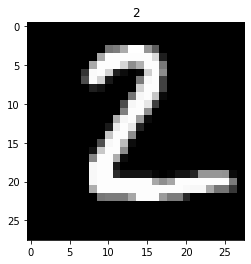

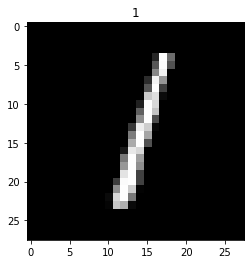

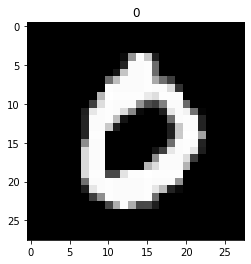

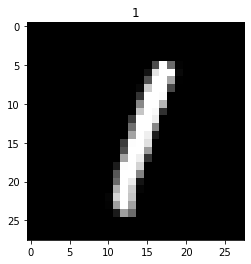

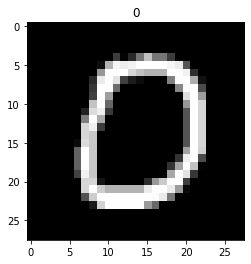

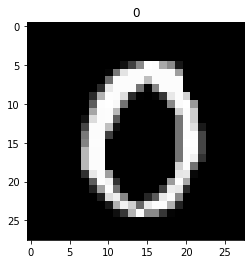

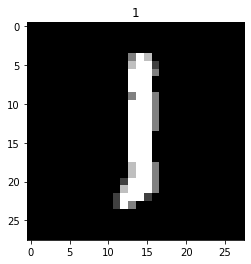

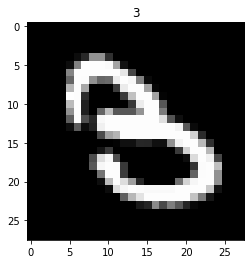

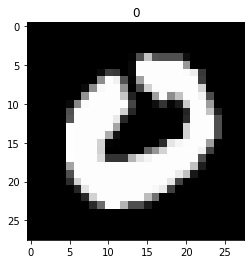

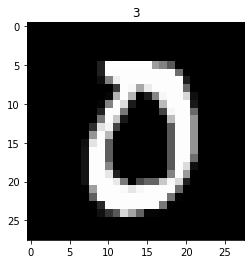

In [ ]:
x, y = le3_test_set, DAG_predictions
for i in range(10):
  check = i
  plt.imshow(np.reshape(x[check],(28,28)),cmap = 'gray')
  plt.title(y[check])
  plt.show()